# Clustering substractivo - Sugeno

In [41]:
# imports
#!pip install scikit-fuzzy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from scipy.optimize import least_squares

In [42]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

# Ra radio interno, Rb radio externo
def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

In [43]:
class Sugeno:
    def __init__(self, data, cluster_alg="K", sigma_mf = 0.1, K=6, Ra=0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
        self.cluster_alg = cluster_alg
        self.K = K
        self.Ra = Ra
        self.Rb = Rb
        self.AcceptRatio=AcceptRatio
        self.RejectRatio=RejectRatio
        self.X = data
        self.fitted = False
        self.sigma_mf = sigma_mf

    def fit_clusters(self):
        """
        Entrena un modelo de clustering.
        
        Opciones:
        - KMeans si cluster_alg = "K"
        - Clustering sustractivo otherwise

        """
        if self.cluster_alg =="K":
            KM = KMeans(n_clusters=self.K, init= 'k-means++', random_state=0, max_iter=400, n_init=10).fit(self.X)
            # me quedo con los labels y los centros
            self.labels = KM.labels_
            self.centers = KM.cluster_centers_
            self.fitted = True
        else:
            self.labels, self.centers = subclust2(self.X, Ra=self.Ra, Rb=self.Rb, AcceptRatio=self.AcceptRatio, RejectRatio=self.RejectRatio)
            self.fitted = True
            # subclust2(X, 0.2, Rb=0, AcceptRatio=0.3, RejectRatio=0.1)

    def get_centers(self):
        """
        Retorna los centros de cluster o None si no se ha entrenado
        """
        if self.fitted:
            return self.centers
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_labels(self):
        """
        Retorna los labels para todos los datos
        o None si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return None

    def get_n_centers(self):
        """
        Retorna la cantidad de centros de cluster, o cero si no se ha entrenado
        """
        if self.fitted:
            return self.labels
        else:
            print("Aun no se ha fiteado ningún modelo")
            return []

    def plot_original_color_by_cluster(self):
        """
        Plotea los datos originales, coloreados por los centros de cluster

        """
        n = self.get_n_centers()
        # print(n)
        if len(n)!=0:
            labels = self.get_labels()
            options_col = np.linspace(0, 1, len(n))
            label_color = [options_col[x] for x in labels]


            plt.figure(figsize=(8,8))
            plt.scatter(self.X[:,1], self.X[:,0], c=label_color)
            plt.title("Datos coloreados con los centros hallados con algoritmo de clustering")

    def get_medias(self):
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

        return medias


    def plot_gaussians(self):
        # me quedo con los centros en la variable independiente (eje x o de tensiones)
        centers = self.get_centers()

        if centers is not None:
            medias = []
            for cx, cy in centers:
                medias.append(cy)
            medias = np.array(medias)
            medias.sort()

            # Ploteo con todas las gaussiandas

            
            x1 = self.X[:,1]
            y1 = self.X[:,0]

            y_t = []
            for med in medias:
                y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) 
            
            self.y_t = y_t
            
            plt.figure(figsize=(8,8))
            plt.plot(x1, y1, 'r', linewidth=2, marker="o")
            for y in y_t:
                plt.plot(x1, y)
            plt.title("Datos con las gaussianas generadas por clustering")

        else:
            print("No es posible plotear porque no se ha inicializado un modelo de cluster")


    def get_sugeno_model_and_plot(self):
        
        x1 = self.X[:,1]
        y1 = self.X[:,0]
        medias = self.get_medias()


        y_t = []

        # El ancho de las gaussianas (desv, es un parametro importante)
        for med in medias:
            y_t.append(fuzz.gaussmf(x1, med, self.sigma_mf)) #ultimo era 0.35

        

        def y(theta, t):
            # salidas lineales todas
            mf = []
            funx = []
            for i in range(len(theta)//2):
                mf.append(fuzz.interp_membership(x1, y_t[i], t))
                funx.append(theta[2*i] * t + theta[2*i+1])
            mf = np.array(mf)
            funx = np.array(funx)
            num =   0
            den = 0
            for i in range(len(theta)//2):
                num += mf[i]*funx[i]
                den += mf[i]
            try :
                resultado =  num/den
            except:
                resultado = None
                print("Division por cero")
            return resultado

        ts = x1
        ys =y1

        def fun(theta):
            return y(theta, ts) - ys


        theta0= [0.1, 0,1]*30
        
        n2 = 2*len(medias)
        res1 = least_squares(fun, theta0[:n2])


        # member lineal
        mse1 = (res1.fun ** 2).mean()
        print("parametros obtenidos mediante least Squares:\n", res1.x)
        print("error cuadratico medio:\n", mse1)




        # ploteo curva obtenida vs datos originales
        y_pred= y(res1.x, x1)

        plt.figure(figsize=(8,8))
        plt.plot(x1, y1, '.r')
        plt.plot(x1, y_pred, 'b')
        if self.cluster_alg=="K":
            str1 = "K means"
        else:
            str1 = "Clustering sustractivo"
        str2 = f"{self.centers.shape[0]} reglas"
        plt.title("Resultado final, curva generada mediante sugeno.\nAlgoritmo de cluster =  "+str1+". "+str2)

In [44]:
f = open("samplesVDA3.txt", "r")

y = []
i=1
for x in f:
    y.append(int(x))
    i=i+1
f.close()

y = np.asarray(y)

y_norm = (y - y.min())/(y.max()-y.min())
x = np.linspace(0,1,y.shape[0])

X11 = np.array([y_norm,x]).T
X11.shape

(153, 2)

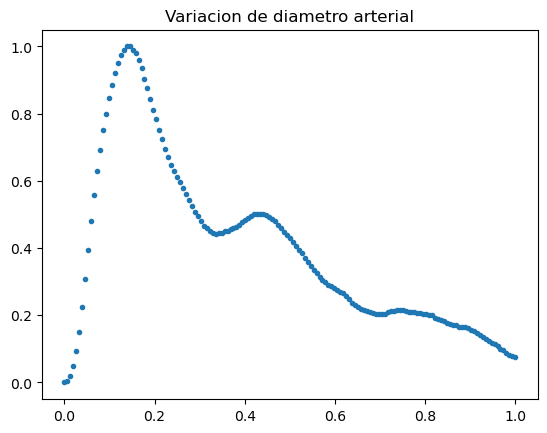

In [45]:

plt.plot(X11[:,1],X11[:,0],'.')
plt.title("Variacion de diametro arterial")
plt.show()

In [46]:
my_sug_VDA = Sugeno(X11, cluster_alg="K", K=15,Ra=0.4)


In [47]:
my_sug_VDA.fit_clusters()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


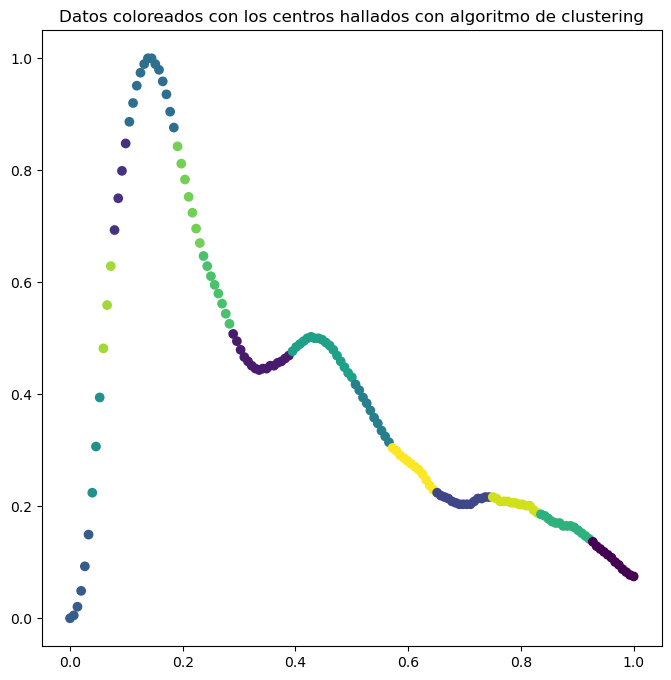

In [48]:
my_sug_VDA.plot_original_color_by_cluster()

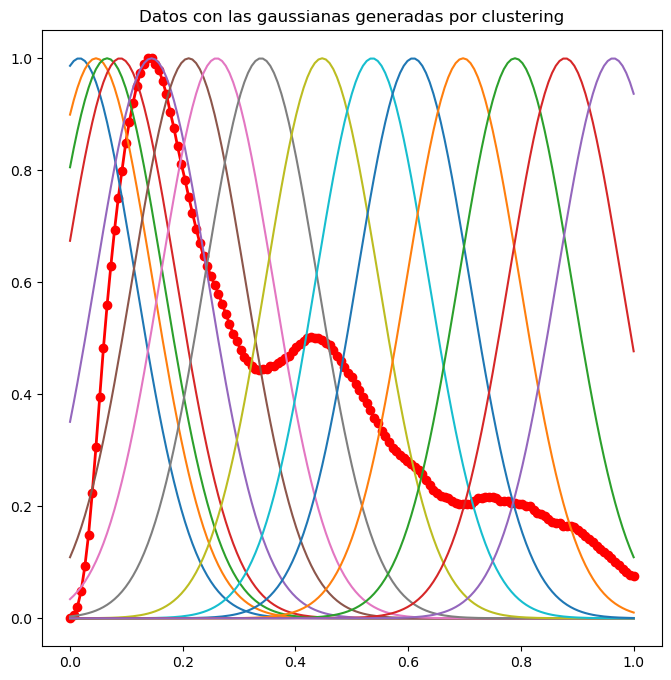

In [49]:
my_sug_VDA.plot_gaussians()

parametros obtenidos mediante least Squares:
 [  72092.16991393   53211.99847484  -88373.00762923 -177586.19598045
  122423.07092298  174571.22761014 -157195.96795181  -52421.24092782
  148764.46699845   20198.53182596     223.22622732  -65015.92683895
  -59212.6666338    61330.27662756  117108.99835076  -41356.75820383
  112156.81911593  -47999.42197464   65532.47032497  -46366.09109823
  -38078.40362738   15691.88952436  -51053.43534972   37899.54066486
  -26630.6848113    23535.09567524   -7712.95576963    8221.282981
    -687.94973515     944.59141984]
error cuadratico medio:
 1.6056823575052743e-05


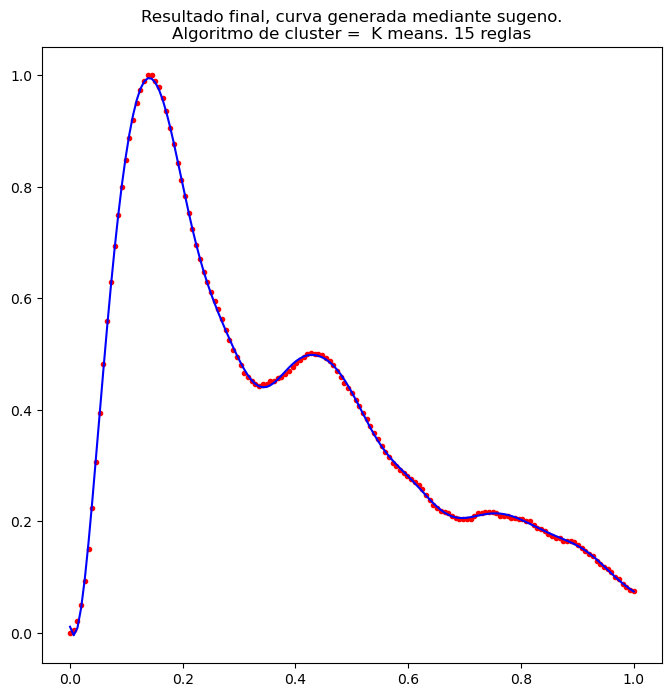

In [50]:
my_sug_VDA.get_sugeno_model_and_plot()